<a href="https://colab.research.google.com/github/ShepherdCode/ShepherdML/blob/master/Nasa2021/CNN_523.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN 523

1. Four layers of CNNS and MaxPooling
2. Drop out at 0.2
3. Variable filters and dense neurons














In [1]:
#NC_FILENAME='ncRNA.tiny50.fasta'
#PC_FILENAME='pcRNA.tiny50.fasta'
#NC_FILENAME='ncRNA.gc34.processed.fasta'
#PC_FILENAME='pcRNA.gc34.processed.fasta'
NC_FILENAME='noncod_3000.fasta'
PC_FILENAME='coding_3000.fasta'

MODEL_FILE='JUNK1' 
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
NC_FILENAME = DATAPATH+NC_FILENAME
PC_FILENAME = DATAPATH+PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=5
SPLITS=1
K=1
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=2
FILTERS=32
KERNEL=3
NEURONS=24
DROP=0.2
MINLEN=200
MAXLEN=1000
DENSE_LEN = 1000
ACT="tanh"

In [2]:
# Load our own tools
# TO DO: don't go to GitHub if the file is already local.
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!
Yahoo!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [4]:
def compile_model(model):
    ## learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    #adam_default_learn_rate = 0.001
    #schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #    initial_learning_rate = adam_default_learn_rate*10,
    #    decay_steps=10000, decay_rate=0.99, staircase=True)
    #alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])

    print("COMPILE...")
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    SHAPE=(MAXLEN,5)  
    SHAPE=(MAXLEN,4)  
    elayer  = keras.layers.Embedding(4,4,input_length=1000)

    clayer1 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same",
                                 input_shape=SHAPE)
    clayer2 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer3 = keras.layers.MaxPooling1D(2)
    clayer4 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer5 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer6 = keras.layers.MaxPooling1D(2)
    clayer7 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer8 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer9 = keras.layers.MaxPooling1D(2)
    clayer10 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer11 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer12 = keras.layers.MaxPooling1D(2)

    clayer13 = keras.layers.Flatten()

    dlayer1 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt, input_shape=[DENSE_LEN])
    dlayer2 = keras.layers.Dropout(DROP)
    dlayer3 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer4 = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)

    cnn = keras.models.Sequential()
    cnn.add(elayer)
    cnn.add(clayer1)
    cnn.add(clayer2)
    cnn.add(clayer3)
    cnn.add(clayer4)
    cnn.add(clayer5)
    cnn.add(clayer6)
    cnn.add(clayer7)
    cnn.add(clayer8)
    cnn.add(clayer9)
    cnn.add(clayer10)
    cnn.add(clayer11)
    cnn.add(clayer12)
    cnn.add(clayer13)
    cnn.add(dlayer1)
    cnn.add(dlayer2)
    cnn.add(dlayer3)
    cnn.add(dlayer4)
    cnn.add(output_layer)
    mlpc = compile_model(cnn)
    return mlpc

Cross validation

In [5]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))
batch_callback = CustomCallback()

In [6]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, 
                epochs=EPOCHS, verbose=1, callbacks=mycallbacks,
                validation_data=(X_valid,y_valid))
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [7]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
#model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 4)           16        
_________________________________________________________________
conv1d (Conv1D)              (None, 1000, 32)          416       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 32)          3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 32)           3104      
_____________________________________________________________

In [8]:
#MINLEN=200
#MAXLEN=2000
FREEMEM=True
print("Load data from files.")
nc_seq=tools.load_fasta(NC_FILENAME,0)
pc_seq=tools.load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
print("Ready: train_set")
subset=tools.make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
if FREEMEM:
    nc_seq=None
    pc_seq=None
    train_set=None
(X1,y_train)=tools.separate_X_and_y(subset)
# X1 is pandas df of ("list" of one sequence)
X2=X1.to_numpy()  # numpy ndarray of ("list" of one sequence)
X3=[elem[0] for elem in X2]  # numpy ndarray of ACGT-str
# X3? It might be faster to use int-array than char-array. Come back to this.
X4=X3  # no-op
print("X4",type(X4))
#print(X4[0])
if FREEMEM:
    X1=None
    X2=None
    X3=None


Load data from files.
Load data from files.
Ready: train_set
X4 <class 'list'>
Ready: train_set
X4 <class 'list'>


In [9]:
X5=[]
dna_to_int = {'A':0,'C':1,'G':2,'T':3}
for x in X4:
    a=[]
    for c in x:
        i = dna_to_int[c]
        a.append(i)
    X5.append(a)
X5=np.asarray(X5)
###X5= np.asarray([list(x) for x in X4])  # SLOW
print("X5",type(X5))
print(X5.shape)
if FREEMEM:
    X4=None
##encoder = OneHotEncoder(sparse=False)
##encoder.fit(X5)
##print("categories:",encoder.categories)
##X_train=encoder.transform(X5).reshape(-1,1000,4)
X_train=X5
if FREEMEM:
    X5=None
print("X_train",type(X_train))
y_train=y_train.to_numpy()
print(X_train.shape)
print(X_train[0].shape)
print(X_train[0])

X5 <class 'numpy.ndarray'>
(6000, 1000)
X_train <class 'numpy.ndarray'>
(6000, 1000)
(1000,)
[2 0 1 0 1 3 1 1 0 2 0 3 3 3 1 1 3 1 2 2 0 3 2 0 2 2 0 2 1 3 3 2 2 3 0 1 2
 3 1 0 1 0 0 0 2 2 3 1 1 2 0 2 2 1 2 0 1 3 1 2 3 2 0 3 1 0 2 2 0 3 1 3 0 0
 0 3 0 0 2 3 3 0 3 2 0 0 0 1 1 2 2 0 1 3 1 2 2 2 3 1 3 2 1 3 0 2 3 1 3 0 0
 1 0 1 3 3 3 3 3 2 2 3 1 0 0 1 3 0 1 0 1 0 0 0 1 2 0 0 0 0 1 2 1 1 2 1 0 2
 1 0 0 0 3 2 1 0 3 0 3 2 2 0 1 2 2 3 3 1 0 0 0 2 1 2 0 0 3 1 3 1 2 0 1 1 2
 0 1 0 2 3 2 3 3 3 0 3 0 0 3 1 1 2 2 0 2 0 2 1 1 1 1 0 3 3 2 0 3 2 0 3 1 0
 0 0 2 2 1 0 0 0 2 3 2 0 1 1 1 1 2 0 2 0 1 2 3 3 3 3 0 1 2 2 2 3 0 1 2 1 3
 1 0 0 1 1 2 0 2 1 2 1 3 1 1 0 1 1 1 2 2 3 0 2 0 3 3 0 2 3 0 0 0 1 3 1 2 3
 1 3 0 0 2 2 2 1 3 3 1 0 3 0 1 0 3 1 1 0 3 1 0 2 2 2 1 1 0 3 1 0 2 1 3 0 1
 1 0 2 3 0 2 1 0 3 3 1 3 2 0 3 0 1 2 1 3 3 1 1 0 0 2 3 0 1 0 3 0 3 2 3 1 3
 3 1 0 1 2 3 3 0 2 0 2 0 3 0 0 2 0 3 1 3 3 2 2 3 1 1 3 3 2 2 0 2 3 3 3 2 2
 2 3 0 1 2 1 1 1 3 0 2 0 3 0 0 0 3 3 2 0 3 1 2 2 0 0 2 2 3 2 1 1 3 1 3 3 2
 1 1 1 

Cross validation
Cross validation
COMPILE...
...COMPILED
FIT
Epoch 1/5
COMPILE...
...COMPILED
FIT
Epoch 1/5
169/169 [==============================] - 22s 121ms/step - loss: 0.6992 - accuracy: 0.4950 - val_loss: 0.6959 - val_accuracy: 0.4800
INFO:tensorflow:Assets written to: data/CNN523.cv.1.best/assets
INFO:tensorflow:Assets written to: data/CNN523.cv.1.best/assets
Epoch 2/5
Epoch 2/5
169/169 [==============================] - 19s 113ms/step - loss: 0.6960 - accuracy: 0.5054 - val_loss: 0.6933 - val_accuracy: 0.4817
INFO:tensorflow:Assets written to: data/CNN523.cv.1.best/assets
INFO:tensorflow:Assets written to: data/CNN523.cv.1.best/assets
Epoch 3/5
Epoch 3/5
169/169 [==============================] - 18s 106ms/step - loss: 0.6938 - accuracy: 0.5039 - val_loss: 0.6755 - val_accuracy: 0.5783
INFO:tensorflow:Assets written to: data/CNN523.cv.1.best/assets
INFO:tensorflow:Assets written to: data/CNN523.cv.1.best/assets
Epoch 4/5
Epoch 4/5
169/169 [==============================] - 18s

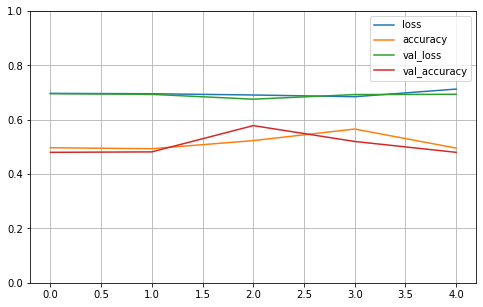

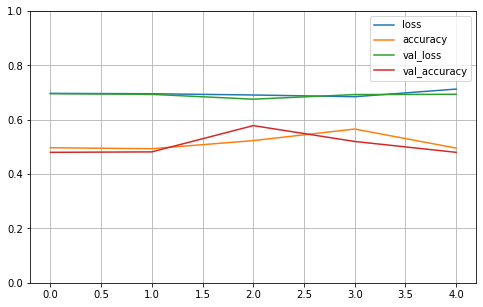

accuracy: 57.83%

1-way Cross Validation mean 57.83% (+/- 0.00%)
Done
accuracy: 57.83%

1-way Cross Validation mean 57.83% (+/- 0.00%)
Done


In [10]:
print ("Cross validation")
do_cross_validation(X_train,y_train,model)  
print ("Done")